created by Ignacio Oguiza - email: oguiza@gmail.com

# How to work with time series in fastai2

In [36]:
import sys
import os
ISCOLAB = 'google.colab' in sys.modules
if ISCOLAB:
    if not os.path.isdir('/content/timeseriesAI2'):
        !pip install git+https://github.com/fastai/fastai2 
        !pip install git+https://github.com/fastai/fastcore 
        !pip install pyunpack
        !pip install sktime
        !git clone https://github.com/timeseriesAI/timeseriesAI2.git
        %cd timeseriesAI2
    else: 
        path = !pwd
        if path != ['/content/timeseriesAI2']: 
            %cd timeseriesAI2
        !pwd

In [37]:
#from nbdev.showdoc import *
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

In [38]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.learner import *
from fastai2.metrics import *
from fastai2.callback.all import *

In [39]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
from timeseries.core import *
from timeseries.models import *

## Load data

In [40]:
# dataset id
dsid = 'StarLightCurves'

In [41]:
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, parent_dir='./data/UCR/', verbose=True, on_disk=True)

Dataset: StarLightCurves
X_train: (1000, 1, 1024)
y_train: (1000,)
X_valid: (8236, 1, 1024)
y_valid: (8236,) 



In [42]:
X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))
folder = './data/UCR'
np.save(f'{folder}/{dsid}/X.npy', X)
np.save(f'{folder}/{dsid}/y.npy', y)
del X, y
X = np.load(f'{folder}/{dsid}/X.npy', mmap_mode='r')
y = np.load(f'{folder}/{dsid}/y.npy', mmap_mode='r')
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X)))))
X.shape, y.shape

((9236, 1, 1024), (9236,))

In [43]:
# This is a convenience function will use later proposed by Thomas Capelle @tcapelle to be able to easily benchmark performance
def cycle_dl(dl):
    for x,y in iter(dl): pass

In [9]:
class TSDatasets(FilteredBase):
    "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, **kwargs):
        super().__init__(dl_type=dl_type)

        #New 4 lines of code
        if tls is None:
            if items is None: items = itemify(X,) if y is None else itemify(X,y)
            assert (tfms is None or len(items[0]) == len(tfms)), f"n_tfms ({len(tfms)}) doesn't match n_items ({len(items[0])})"
            tfms = None if tfms is None else [[ItemGetter(i)] + L(tfms[i]) for i in range(len(items[0]))]
        self.tls = L(tls if tls else [TfmdLists(TfmdLists(items, t, **kwargs)[:len(items)], ToTSTensor, **kwargs) for t in L(ifnone(tfms,[None]))])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp
        self.tfms = tfms
        self.X, self.y = X, y

    def __getitem__(self, it):
        res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))

    def __getattr__(self,k): return gather_attrs(self, k, 'tls')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
    def __len__(self): return len(self.tls[0])
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __repr__(self): return coll_repr(self)
    def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
    def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    def overlapping_splits(self): return self.tls[0].overlapping_splits()
    @property
    def splits(self): return self.tls[0].splits
    @property
    def split_idx(self): return self.tls[0].tfms.split_idx
    @property
    def items(self): return self.tls[0].items
    @items.setter
    def items(self, v):
        for tl in self.tls: tl.items = v

    @property
    def c(self): return len(np.unique(self.y)) if self.y is not None else 0
    
    def show(self, o, ctx=None, **kwargs):
        for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
        return ctx

    def new_empty(self):
        tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
        return type(self)(tls=tls, n_inp=self.n_inp)

    @contextmanager
    def set_split_idx(self, i):
        old_split_idx = self.split_idx
        for tl in self.tls: tl.tfms.split_idx = i
        yield self
        for tl in self.tls: tl.tfms.split_idx = old_split_idx

In [10]:
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)

In [11]:
# A single item as stored in items (class np.memmap --> on disk)
dsets.items[0]

memmap([[0.5373029 , 0.53110296, 0.52850294, ..., 0.52640295, 0.51950294,
         0.51140296]], dtype=float32)

In [12]:
# In memory
dsets[0]

(TSTensor(vars:1, len:1024), TensorCategory(2))

In [13]:
len(dsets.train), len(dsets.valid)

(1000, 8236)

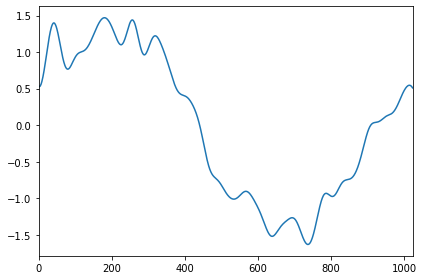

In [14]:
dsets.show(dsets.train[0]);

In [15]:
class TSTfmdDL(TfmdDL): 

    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def len(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        if b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if nrows is None: 
            sqrt = math.sqrt(len(db))
            rows = min(math.ceil(sqrt), len(db)) 
        if ncols is None: ncols = len(db) // rnows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(db[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()): 
            show_tuple(tup, ax=ax)
        plt.tight_layout()

    def test_dl(self:DataLoaders, test_items, rm_type_tfms=None, with_labels=False, **kwargs):
        "Create a test dataloader from `test_items` using validation transforms of `dls`"
        test = test_set(self.valid, test_items, rm_tfms=rm_type_tfms, with_labels=with_labels
                        ) if isinstance(self.valid, (Datasets, NumpyDatasets, TSDatasets, TfmdLists)) else test_items
        return self.valid.new(test, **kwargs)

@delegates(plt.subplots)
def show_tuple(tup, ax=None, **kwargs):
    "Display a timeseries plot from a tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], ax=ax, **kwargs)

In [16]:
dls = TSTfmdDL(dsets, bs=64, val_bs=128)

In [25]:
b = dls.one_batch()
b

(TSTensor(samples:64, vars:1, len:1024),
 TensorCategory([2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0,
         2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2,
         0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0]))

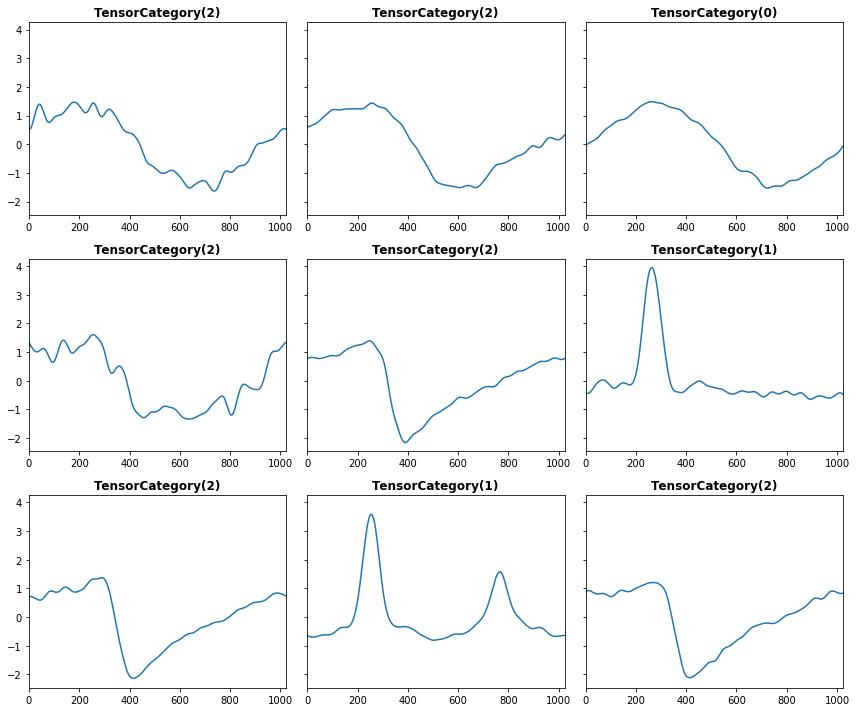

In [18]:
dls.show_batch(nrows=3, ncols=3, figsize=(12, 10), sharey=True)

In [33]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(np.array(X), np.array(y), tfms=tfms, splits=splits)
dls_in_memory   = TSTfmdDL(dsets, bs=64, val_bs=128)

In [34]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls_on_disk   = TSTfmdDL(dsets, bs=64, val_bs=128)

In [35]:
# Data in memory
%timeit cycle_dl(dls_in_memory.valid)

4.19 s ± 745 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
# Data on disk
%timeit cycle_dl(dls_on_disk.valid)

1 loop, best of 3: 2.92 s per loop


## Train model

In [96]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
dls   = TSTfmdDL(dsets, bs=64, val_bs=128)
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls.dataloaders(), model, loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learn.fit_one_cycle(25, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.672128,1.020081,0.577222,00:07
1,0.550203,0.691641,0.846527,00:07
2,0.474273,0.389601,0.850656,00:07
3,0.404929,0.511200,0.844099,00:07
4,0.351931,0.736974,0.855998,00:07
5,0.295894,0.232067,0.917557,00:07
6,0.248009,0.317687,0.853570,00:07
7,0.213790,0.484034,0.781204,00:07
8,0.190101,0.302354,0.871782,00:07
9,0.168933,0.246571,0.876639,00:07


## Add test set

In [0]:
def add_data(dsets, X=None, y=None, test_items=None, rm_tfms=None, with_labels=False):
    "Create a test or unlabeled sets from `items` using validation transforms of `dsets`"
    items = itemify(X,) if y is None else itemify(X, y)
    if y is None: with_labels = False
    else: with_labels = True
    if isinstance(dsets, (Datasets, NumpyDatasets)):
        tls = dsets.tls if with_labels else dsets.tls[:dsets.n_inp]
        new_tls = [tl._new(items, split_idx=1) for tl in tls]
        if rm_tfms is None: rm_tfms = [tl.infer_idx(get_first(items)) for tl in new_tls]
        else:               rm_tfms = tuplify(rm_tfms, match=new_tls)
        for i,j in enumerate(rm_tfms): new_tls[i].tfms.fs = new_tls[i].tfms.fs[j:]
        if isinstance(dsets, Datasets):return Datasets(tls=new_tls)
        else: return NumpyDatasets(tls=new_tls)
    elif isinstance(dsets, TfmdLists):
        new_tl = dsets._new(items, split_idx=1)
        if rm_tfms is None: rm_tfms = dsets.infer_idx(get_first(items))
        new_tl.tfms.fs = new_tl.tfms.fs[rm_tfms:]
        return new_tl
    else: raise Exception(f"This method requires using the fastai library to assemble your data.Expected a `Datasets` or a `TfmdLists` but got {dsets.__class__.__name__}")

NumpyDatasets.add_data = add_data

In [92]:
tfms    = [None, [Categorize()]]
dsets   = TSDatasets(X, y, tfms=tfms, splits=splits)
tst_set = dsets.add_data(X)
tst_dl  = TSTfmdDL(tst_set, bs=128)
b       = tst_dl.one_batch()
b

(TSTensor(samples:128, vars:1, len:1024),)

In [93]:
tst_set.tls[0].tfms

Pipeline: itemgetter -> ToTSTensor

In [94]:
tfms    = [None, [Categorize()]]
dsets   = TSDatasets(X, y, tfms=tfms, splits=splits)
tst_set = dsets.add_data(X, y)
tst_dl  = TSTfmdDL(tst_set, bs=128)
b       = tst_dl.one_batch()
b

(TSTensor(samples:128, vars:1, len:1024),
 TensorCategory([2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 0,
         2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 1, 2,
         0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 1, 1, 2,
         1, 0, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1,
         2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1,
         2, 2, 2, 2, 1, 2, 0, 2]))

## Unlabeled datasets

In [95]:
tfms  = None
dsets = TSDatasets(X, tfms=tfms, splits=splits)
uset  = dsets.add_data(X)
udl   = TSTfmdDL(uset, bs=128)
xb    = udl.one_batch()
xb

(TSTensor(samples:128, vars:1, len:1024),)